In [126]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Week of 6/21
Start embedding your model understanding into computational frameworks. So as an exercise, take a stab at implementing the Hodgkin Huxley model for numerical solution, e.g. using scipy (odeint or newer methods).

## Hodgkin-Huxley Model

In [127]:
def plot_vnmh(x,t):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #Extract variables from matrix
    V = x[:,0]
    n = x[:,1]
    m = x[:,2]
    h = x[:,3]

    #plot the results
    plt.figure(figsize=(15,10))
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')

    plt.subplot(211)
    plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
    plt.ylabel("Volts (V)", fontsize=label_font)
    plt.xlabel("Time (s)", fontsize=label_font)
    plt.plot(t,V)
    plt.subplot(212)
    plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
    plt.ylabel("Volts (V)", fontsize=label_font)
    plt.xlabel("Time (s)", fontsize=label_font)
    plt.plot(t,n,label="n")
    plt.plot(t,m,label="m")
    plt.plot(t,h,label="h")
    plt.legend(loc="upper left")
    plt.show()

In [128]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not sure if this is actually needed (not called in func)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    #Maybe this should be I - sum(gE-gV)?
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h

    return dVdt, dndt, dmdt, dhdt

In [129]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

BURN IN: instead of using the random, clean x0 initial conditions I found, we should use burn in to find what the true steady state of our system is.  I.e. let it run for a really long time and whatever it equilibriates to is what we will use for "true" SS going forward:

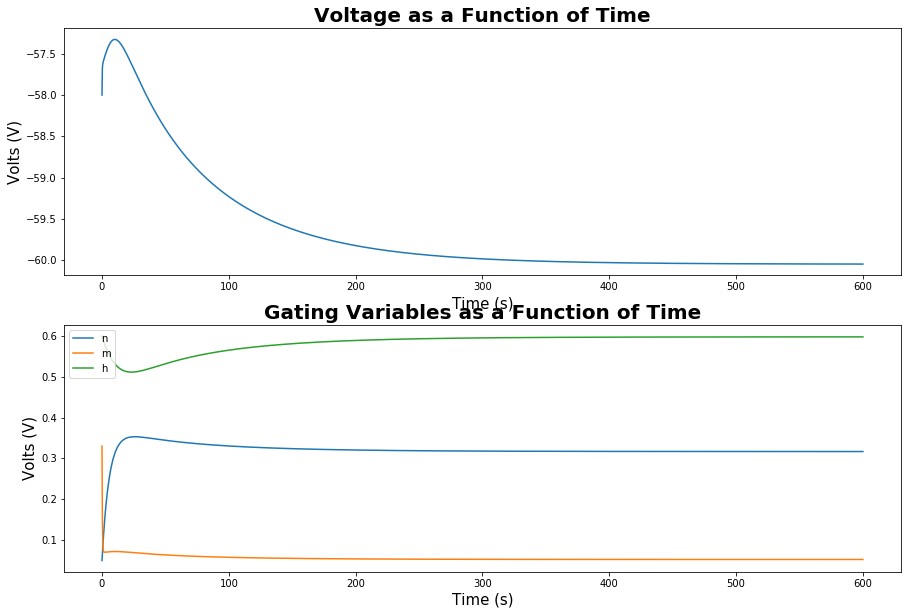

In [130]:
#initial condition
x0 = [-58, 0.05, 0.33, 0.6] #Found online... not sure if these are correct
#time vector
t = np.linspace(0,600,2000)
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

In [131]:
print("Comparing our original x0 to what our system of differntial equations seems to prefer as SS:")
print(x0)
x0_new = x[-1,:]
print(x0_new)

Comparing our original x0 to what our system of differntial equations seems to prefer as SS:
[-58, 0.05, 0.33, 0.6]
[-6.00455678e+01  3.16980595e-01  5.26487042e-02  5.97706990e-01]


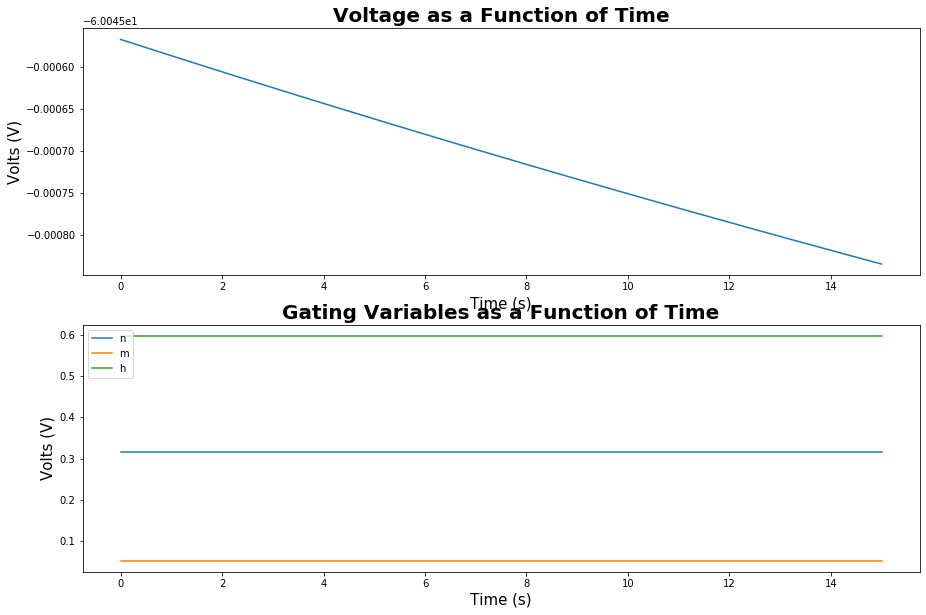

In [132]:
#BURNED IN initial condition
#time vector
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

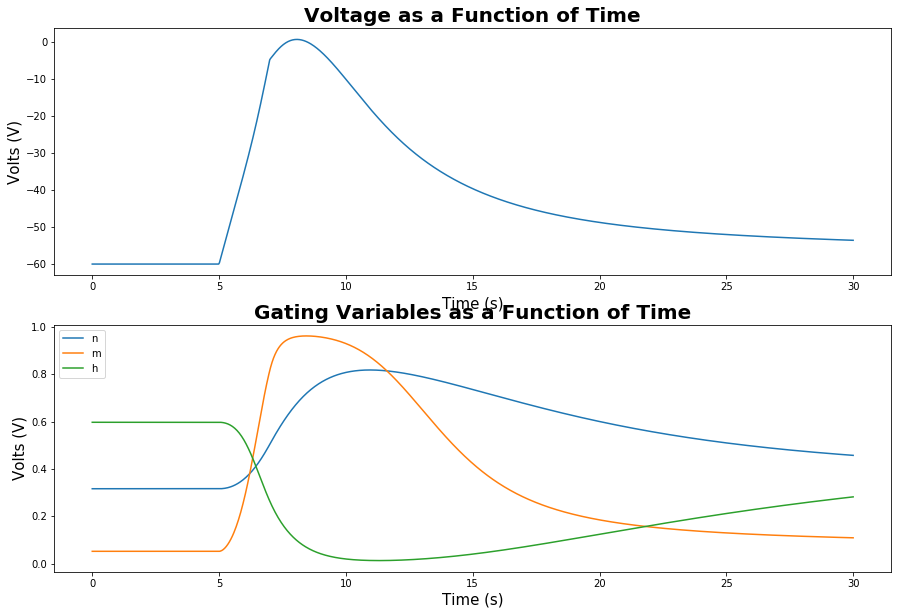

In [133]:
t = np.linspace(0,30,1000) #ms
#NOW SETTING vI to something realistic:
vI = [5,7,25]

x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

plot_vnmh(x,t)

## Tasks Post 6/23 Meeting:
1. Fix the above to generate a real HH AP
2. SYNAPTICALLY COUPLED NEURONS: Choose the reversal potential to be the same as the sodium current (Excitatory synapse)
3. Start with synpatic g of 0 to verify 
4. Then begin increasing both g's --> numerically find some minimal set of g's, FIND SUSTAINED OSCILLATION OF CONTINUOUS SPIKING
5. Update units/axes